#  Ice Cream and Frozen Dessert Stock Prediction by Time

# Data view

👉 This study will examine the dataset named as **"Industrial Production: Manufacturing: Non-Durable Goods: Ice Cream and 

Frozen Dessert (NAICS = 31152)"** at website of KFRED, Federal Reserve Bank of St. Louis; 

https://fred.stlouisfed.org/series/IPN31152N

Frequency: Monthly

Industrial Production: Manufacturing: Non-Durable Goods: Ice Cream and Frozen Dessert (NAICS = 31152) Endüstriyel Üretim: İmalat: Dayanıksız Mallar: Dondurma ve Dondurulmuş Tatlı

In [923]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns 

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,6)
#plt.rcParams['figure.dpi'] = 100 (#to adjust figure resolution)
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

from sklearn.preprocessing import MinMaxScaler


In [924]:
df = pd.read_csv("Frozen_Dessert_Production.csv")

In [925]:
df.head()

,DATE,IPN31152N
0,1972-01-01,60.152
1,1972-02-01,67.273
2,1972-03-01,74.470
3,1972-04-01,78.360
4,1972-05-01,85.032


In [926]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DATE       611 non-null    object 
 1   IPN31152N  611 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.7+ KB


In [927]:
df = pd.read_csv("Frozen_Dessert_Production.csv", parse_dates=['DATE'], index_col="DATE") 
#parse_dates object olan Date sutünunu datetime'a çevirir.
#index_col belirtilen sütunu index yapar.

In [928]:
df.head()

,IPN31152N
DATE,
1972-01-01,60.152
1972-02-01,67.273
1972-03-01,74.470
1972-04-01,78.360
1972-05-01,85.032


In [929]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 611 entries, 1972-01-01 to 2022-11-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  611 non-null    float64
dtypes: float64(1)
memory usage: 9.5 KB


In [930]:
df.isnull().sum()

IPN31152N    0
dtype: int64

In [931]:
df.shape

(611, 1)

In [932]:
df.columns= ["Production"]  #tek sütunum olan "IPN31152N" ismini değiştirdim.

In [933]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Production,611.000,109.785,27.398,58.846,89.185,107.721,127.271,196.817


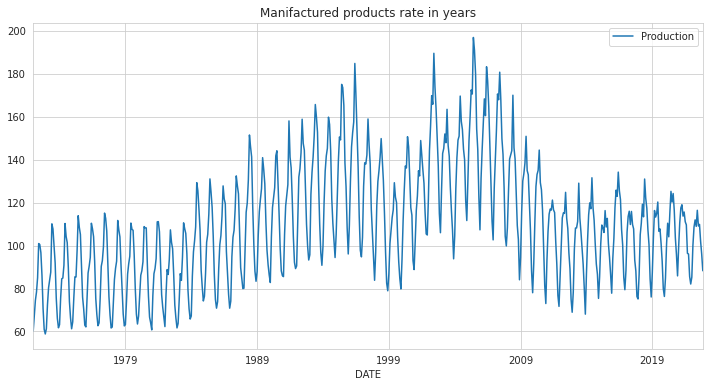

In [934]:
df.plot(figsize=(12,6));
plt.title("Manifactured products rate in years");

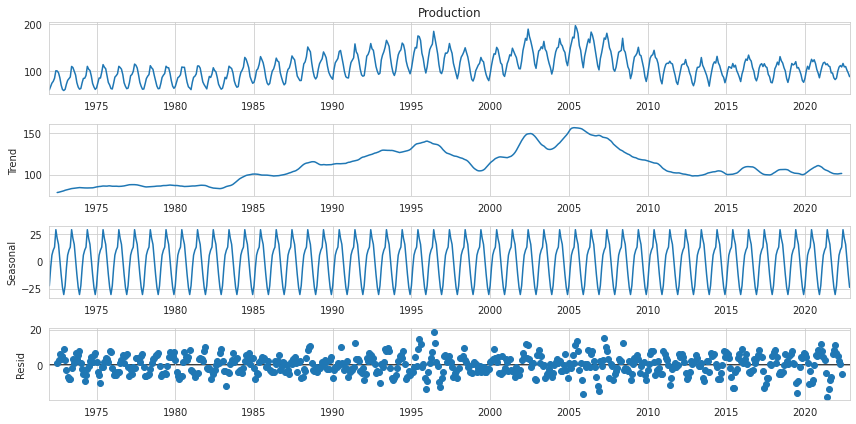

In [935]:
from statsmodels.tsa.seasonal import seasonal_decompose

results = seasonal_decompose(df['Production'])
results.plot();

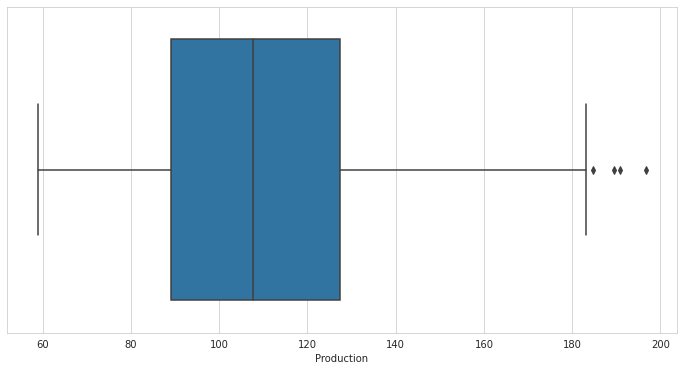

In [936]:
sns.boxplot(x= "Production", data=df);

In [937]:
# Some statical test can be applied data to understand the data is normally distributed or not, p value < 0.05 or not.
# Shapiro test(veri normal dağılıma sahip mi).
# Dickey Fuller Test(P value içeren skorlar.p için kritik value 0.05.bu eşikten küçük olmasını isteriz.)
# Datamız normal dağılıma yakın olduğunda dahan kararlı oluyor.Stationary deniyor buna.

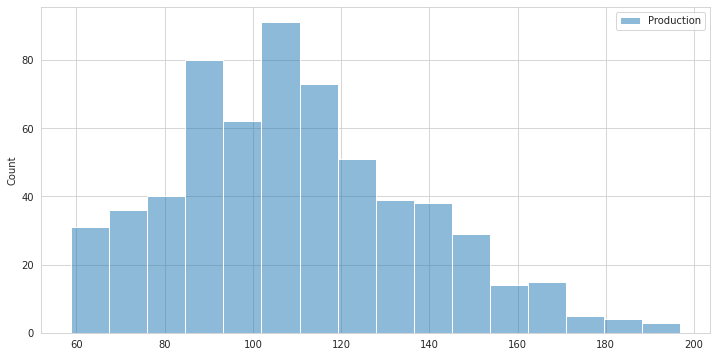

In [938]:
sns.histplot(df)

In [939]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 611 entries, 1972-01-01 to 2022-11-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Production  611 non-null    float64
dtypes: float64(1)
memory usage: 9.5 KB


# Prep Data for Model

## Train Test Split

In [940]:
len(df)

611

In [941]:
test_size = 24   # 12 ayda bir tekrar ediyor data, o yüzden 12 den daha büyük seçmem gerek.

In [942]:
len(df) - test_size 

587

In [943]:
train = df.iloc[:587]
test = df.iloc[587:]
len(train), len(test)

(587, 24)

In [944]:
train.head()

,Production
DATE,
1972-01-01,60.152
1972-02-01,67.273
1972-03-01,74.470
1972-04-01,78.360
1972-05-01,85.032


## Scaling

In [945]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [946]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [947]:
train_scaled[:5]

array([[0.00946792],
       [0.06107946],
       [0.11324473],
       [0.14143469],
       [0.18979772]])

## Time Series Generator

In [948]:
# help(TimeseriesGenerator)
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator

In [949]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [950]:
#define generator 
#generator scale edilmiş train verisini verilen parametre bilgilerini saklayacak şekilde arraylarden oluşan timeseriesgenerator objesine dönüştürür.

length = 6  # döngü #uzunluk aralığı, test sizedan daha kısa olmalıdır
generator = TimeseriesGenerator(train_scaled, train_scaled, length=length, batch_size=1)

# TimeseriesGenerator(data,target,lenght,batch_size...)
  # Data ile target AYNI OLMALI!
  # Length of the output sequences (in number of timesteps).Lenght 3 ise 3 veriyi işler,tutar 4.tahmin eder.Lenght 12 ise 12 satırı işler,tutar 13.yü tahmin eder.
  # batch_size limits the number of samples to be shown to the network.
    #Specifically, the batch size used when fitting your model controls how many predictions you must make at a time.
    #Datam küçük olduğu için batch_size=1 daha iyi skor verir.Daha uzun datalarda çalışınca batch size ile mecburen oynayacağız.


In [951]:
generator[0]

(array([[[0.00946792],
         [0.06107946],
         [0.11324473],
         [0.14143469],
         [0.18979772],
         [0.30491313]]]), array([[0.30149792]]))

In [952]:
type(generator)

keras.preprocessing.sequence.TimeseriesGenerator

In [953]:
# generator modelimin aradığı veri düzenin oluşturdu bana.
# ürettiği ilk eleman ise bu aşağıdaki. 
# bu 12 değerden 13.yü tahmin edecek..

generator[0]

(array([[[0.00946792],
         [0.06107946],
         [0.11324473],
         [0.14143469],
         [0.18979772],
         [0.30491313]]]), array([[0.30149792]]))

In [954]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')  # gösterimi daha rahat olsun diye flatten yaptık. Yoksa array içinde çıkacaktı.
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00946792 0.06107946 0.11324473 0.14143469 0.18979772 0.30491313]
Predict this y: 
 [[0.30149792]]


# Modelling & Model Performance

In [955]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from keras.layers import Dropout


In [956]:
# Zaman serimizde yalnızca bir sutün=özellik=feature=attribute kullanıyoruz.
n_features = 1

In [957]:
# define model
model = Sequential()
model.add(LSTM(120, activation='relu', input_shape=(length, n_features)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')  # loss value için continuous veri ile cont. veri karşılaştırmak için mse seçtim. Reg de olduğu gibi.

## EaryStop and Validation

In [958]:
from tensorflow.keras.callbacks import EarlyStopping

In [959]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

In [960]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)
#doğrulanacak generator

In [961]:
len(validation_generator)
# son 24 taneyi test için ayırdık, bunların içinden stride 1 olacak şekilde 
# 12 lik gruplar halinde ve kaydıra kaydıra işlem yaparak 12 tane değer üretti. 

18

In [962]:
model.fit_generator(generator, epochs = 50,
                    validation_data = validation_generator,
                    callbacks = [early_stop])  #callback içine early stop konabilir.Öncesinde tanımlayabilirsin.

Epoch 1/50
581/581 [==============================] - 9s 11ms/step - loss: 0.0282 - val_loss: 0.0121
Epoch 2/50
581/581 [==============================] - 6s 10ms/step - loss: 0.0172 - val_loss: 0.0026
Epoch 3/50
581/581 [==============================] - 3s 5ms/step - loss: 0.0139 - val_loss: 0.0093
Epoch 4/50
581/581 [==============================] - 3s 5ms/step - loss: 0.0102 - val_loss: 0.0029
Epoch 5/50
581/581 [==============================] - 3s 5ms/step - loss: 0.0090 - val_loss: 0.0023
Epoch 6/50
581/581 [==============================] - 3s 5ms/step - loss: 0.0086 - val_loss: 0.0024
Epoch 7/50
581/581 [==============================] - 3s 5ms/step - loss: 0.0076 - val_loss: 0.0042
Epoch 8/50
581/581 [==============================] - 3s 5ms/step - loss: 0.0078 - val_loss: 0.0016
Epoch 9/50
581/581 [==============================] - 3s 5ms/step - loss: 0.0064 - val_loss: 0.0018
Epoch 10/50
581/581 [==============================] - 3s 5ms/step - loss: 0.0062 - val_loss: 0.00

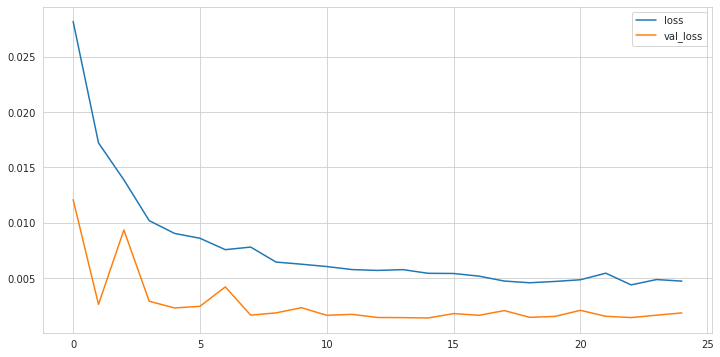

In [963]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot();

# Evaluate test data

In [964]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [965]:
def eval_metrics(actual, pred):  # all evaluating metrics loop
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [966]:
y_pred = model.predict(validation_generator)  
# valid generator 24-12 = 12 taneydi
# son 24 taneyi kontrol için ayırdık, ve bu 24 tane içinden stride 1 olacak şekilde 12 ler halinde 12 tane çıktı aldı olay aslında bu.

18/18 [==============================] - 0s 2ms/step


In [969]:
y_pred

array([[0.33935922],
       [0.32684112],
       [0.31485236],
       [0.33084053],
       [0.23145887],
       [0.22399436],
       [0.19607478],
       [0.18661411],
       [0.2533651 ],
       [0.33336213],
       [0.40582764],
       [0.4018328 ],
       [0.3367372 ],
       [0.34795475],
       [0.30536044],
       [0.31403536],
       [0.25960878],
       [0.21497759]], dtype=float32)

In [970]:
eval_metrics(test_scaled[-18:], y_pred) 

r2_score: 0.6961378071906312 
 mae: 0.03576755320936958 
 mse: 0.0018383128135287337 
 rmse: 0.042875550300010536


In [971]:
test_predictions = []  #Bu test döngüsünde hatalar kümülatif toplanıyor.Hatalar çok yüksek çıkıyor.

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

        
# train datamızın sonundan 12lik bir parçayı aldık. bu bizim ilk eval_batch imiz olacak. bundan ileriye forecast yapacak.
# sonra bunu reshape yaptık (1,12,1) oldu  ( (1, length, n_features) )
# bundan for döngüsü içinde current_batch i hep bir ilerletecek şekilde predict ler alıp alıp test_prediction a kaydettim. 

1/1 [==============================] - 0s 19ms/step


## Inverse Transformations and Comparing

In [972]:
true_predictions = scaler.inverse_transform(test_predictions)

In [973]:
test['Predictions'] = true_predictions

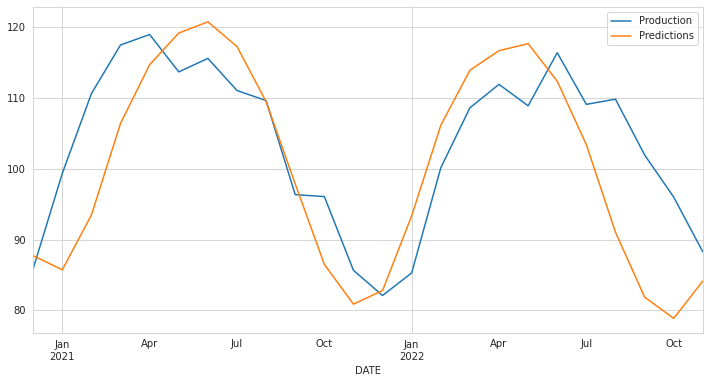

In [974]:
test.plot();

In [975]:
eval_metrics(test.Production, test.Predictions)

r2_score: 0.2817909276655869 
 mae: 7.682973750282265 
 mse: 90.97971042327238 
 rmse: 9.538328492103446


## 2nd try

---LSTM 100

---Activation function "tanh"

---Validatin generator model.fit'e dahil.

In [976]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(100, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer = 'rmsprop', loss = 'mse')

In [977]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 8)
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)
len(validation_generator)

18

In [978]:
model.fit_generator(generator, epochs = 50,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/50
581/581 [==============================] - 7s 6ms/step - loss: 0.0255 - val_loss: 0.0054
Epoch 2/50
581/581 [==============================] - 3s 5ms/step - loss: 0.0122 - val_loss: 0.0019
Epoch 3/50
581/581 [==============================] - 3s 5ms/step - loss: 0.0079 - val_loss: 0.0028
Epoch 4/50
581/581 [==============================] - 3s 5ms/step - loss: 0.0077 - val_loss: 0.0028
Epoch 5/50
581/581 [==============================] - 3s 5ms/step - loss: 0.0070 - val_loss: 0.0020
Epoch 6/50
581/581 [==============================] - 3s 5ms/step - loss: 0.0068 - val_loss: 0.0085
Epoch 7/50
581/581 [==============================] - 3s 5ms/step - loss: 0.0064 - val_loss: 0.0022
Epoch 8/50
581/581 [==============================] - 3s 5ms/step - loss: 0.0062 - val_loss: 0.0020
Epoch 9/50
581/581 [==============================] - 3s 5ms/step - loss: 0.0065 - val_loss: 0.0021
Epoch 10/50
581/581 [==============================] - 3s 5ms/step - loss: 0.0060 - val_loss: 0.0018

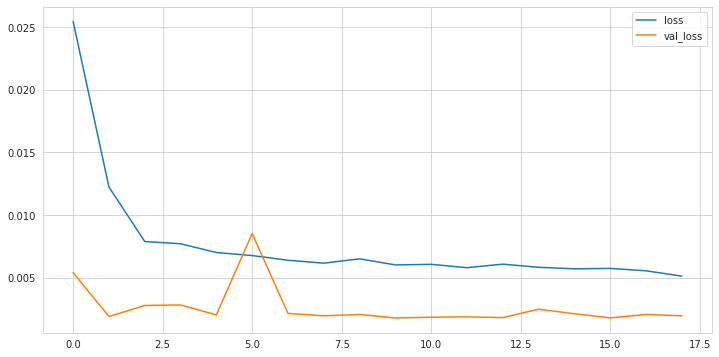

In [979]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [980]:
y_pred = model.predict(validation_generator)

18/18 [==============================] - 1s 4ms/step


In [991]:
eval_metrics(test_scaled[-18:], y_pred)  #tanh activation fonksiyonu daha düşük sonuç verdi.

r2_score: 0.6751918771297792 
 mae: 0.0349297794137666 
 mse: 0.0019650320057590666 
 rmse: 0.044328681525160056


In [984]:
test_predictions = []  #Bu prediction loop'taki test yöntemi hatalarıb kümülatif olarak toplanarak gitmesini sağlıyor.Bu yüzden hata yüksek çıkıyor.

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

1/1 [==============================] - 0s 24ms/step


In [985]:
#Scale olayını geri almamız gerekli.
true_predictions = scaler.inverse_transform(test_predictions)

In [986]:
test['Predictions'] = true_predictions

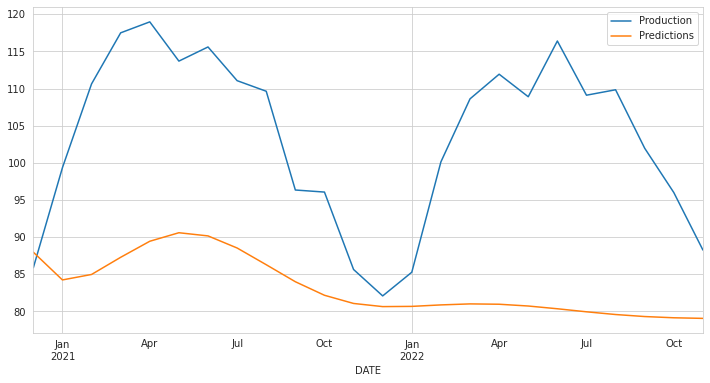

In [987]:
test.plot()

In [988]:
eval_metrics(test.Production, test.Predictions)   #Çok düşük nerede hata var?sıra önemli bu işte.sıra mı karıştı?

r2_score: -2.989436683112848 
 mae: 20.166239462927418 
 mse: 505.3650923704657 
 rmse: 22.480326785224136


# 3.try

---validation generation modele dahil değil

---LSTM 120

In [992]:
model = Sequential()
model.add(LSTM(120, activation = 'relu', input_shape = (length, n_features))) 
model.add(Dropout(0.2))
model.add(Dense(1)) 
model.compile(optimizer = 'adam', loss = 'mse')

In [993]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 8)

In [994]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)

In [995]:
model.fit_generator(generator, epochs = 50,
                    callbacks = [early_stop])

Epoch 1/50
578/581 [============================>.] - ETA: 0s - loss: 0.0292

581/581 [==============================] - 4s 4ms/step - loss: 0.0291
Epoch 2/50
570/581 [============================>.] - ETA: 0s - loss: 0.0172

581/581 [==============================] - 3s 5ms/step - loss: 0.0170
Epoch 3/50
572/581 [============================>.] - ETA: 0s - loss: 0.0140

581/581 [==============================] - 3s 5ms/step - loss: 0.0140
Epoch 4/50
578/581 [============================>.] - ETA: 0s - loss: 0.0110

581/581 [==============================] - 3s 5ms/step - loss: 0.0109
Epoch 5/50
577/581 [============================>.] - ETA: 0s - loss: 0.0087

581/581 [==============================] - 4s 6ms/step - loss: 0.0087
Epoch 6/50
572/581 [============================>.] - ETA: 0s - loss: 0.0077

581/581 [==============================] - 3s 5ms/step - loss: 0.0076
Epoch 7/50
576/581 [============================>.] - ETA: 0s - loss: 0.0069

581/581 [==============================] - 3s 5ms/step - loss: 0.0069
Epoch 8/50
576/581 [============================>.] - ETA: 0s - loss: 0.0064

581/581 [==============================] - 3s 5ms/step - loss: 0.0064
Epoch 9/50
571/581 [============================>.] - ETA: 0s - loss: 0.0062

581/581 [==============================] - 3s 5ms/step - loss: 0.0061
Epoch 10/50
570/581 [============================>.] - ETA: 0s - loss: 0.0063

581/581 [==============================] - 3s 5ms/step - loss: 0.0062
Epoch 11/50
578/581 [============================>.] - ETA: 0s - loss: 0.0056

581/581 [==============================] - 3s 5ms/step - loss: 0.0055
Epoch 12/50
574/581 [============================>.] - ETA: 0s - loss: 0.0057

581/581 [==============================] - 3s 5ms/step - loss: 0.0057
Epoch 13/50
579/581 [============================>.] - ETA: 0s - loss: 0.0054

581/581 [==============================] - 3s 5ms/step - loss: 0.0054
Epoch 14/50
571/581 [============================>.] - ETA: 0s - loss: 0.0047

581/581 [==============================] - 3s 5ms/step - loss: 0.0047
Epoch 15/50
573/581 [============================>.] - ETA: 0s - loss: 0.0047

581/581 [==============================] - 3s 5ms/step - loss: 0.0047
Epoch 16/50
577/581 [============================>.] - ETA: 0s - loss: 0.0049

581/581 [==============================] - 3s 5ms/step - loss: 0.0049
Epoch 17/50
571/581 [============================>.] - ETA: 0s - loss: 0.0050

581/581 [==============================] - 3s 5ms/step - loss: 0.0050
Epoch 18/50
576/581 [============================>.] - ETA: 0s - loss: 0.0046

581/581 [==============================] - 3s 5ms/step - loss: 0.0048
Epoch 19/50
572/581 [============================>.] - ETA: 0s - loss: 0.0046

581/581 [==============================] - 3s 4ms/step - loss: 0.0046
Epoch 20/50
570/581 [============================>.] - ETA: 0s - loss: 0.0046

581/581 [==============================] - 3s 5ms/step - loss: 0.0046
Epoch 21/50
581/581 [==============================] - ETA: 0s - loss: 0.0048

581/581 [==============================] - 3s 6ms/step - loss: 0.0048
Epoch 22/50
575/581 [============================>.] - ETA: 0s - loss: 0.0045

581/581 [==============================] - 4s 6ms/step - loss: 0.0045
Epoch 23/50
571/581 [============================>.] - ETA: 0s - loss: 0.0048

581/581 [==============================] - 3s 5ms/step - loss: 0.0047
Epoch 24/50
579/581 [============================>.] - ETA: 0s - loss: 0.0043

581/581 [==============================] - 3s 5ms/step - loss: 0.0043
Epoch 25/50
581/581 [==============================] - ETA: 0s - loss: 0.0041

581/581 [==============================] - 3s 5ms/step - loss: 0.0041
Epoch 26/50
575/581 [============================>.] - ETA: 0s - loss: 0.0046

581/581 [==============================] - 3s 5ms/step - loss: 0.0046
Epoch 27/50
575/581 [============================>.] - ETA: 0s - loss: 0.0044

581/581 [==============================] - 3s 5ms/step - loss: 0.0044
Epoch 28/50
577/581 [============================>.] - ETA: 0s - loss: 0.0042

581/581 [==============================] - 3s 5ms/step - loss: 0.0042
Epoch 29/50
575/581 [============================>.] - ETA: 0s - loss: 0.0042

581/581 [==============================] - 3s 5ms/step - loss: 0.0042
Epoch 30/50
579/581 [============================>.] - ETA: 0s - loss: 0.0045

581/581 [==============================] - 3s 5ms/step - loss: 0.0045
Epoch 31/50
578/581 [============================>.] - ETA: 0s - loss: 0.0040

581/581 [==============================] - 3s 5ms/step - loss: 0.0040
Epoch 32/50
578/581 [============================>.] - ETA: 0s - loss: 0.0040

581/581 [==============================] - 3s 5ms/step - loss: 0.0041
Epoch 33/50
575/581 [============================>.] - ETA: 0s - loss: 0.0042

581/581 [==============================] - 3s 5ms/step - loss: 0.0042
Epoch 34/50
575/581 [============================>.] - ETA: 0s - loss: 0.0040

581/581 [==============================] - 3s 5ms/step - loss: 0.0040
Epoch 35/50
577/581 [============================>.] - ETA: 0s - loss: 0.0038

581/581 [==============================] - 3s 5ms/step - loss: 0.0038
Epoch 36/50
576/581 [============================>.] - ETA: 0s - loss: 0.0039

581/581 [==============================] - 3s 5ms/step - loss: 0.0038
Epoch 37/50
571/581 [============================>.] - ETA: 0s - loss: 0.0039

581/581 [==============================] - 3s 5ms/step - loss: 0.0038
Epoch 38/50
575/581 [============================>.] - ETA: 0s - loss: 0.0040

581/581 [==============================] - 3s 5ms/step - loss: 0.0040
Epoch 39/50
574/581 [============================>.] - ETA: 0s - loss: 0.0035

581/581 [==============================] - 3s 5ms/step - loss: 0.0035
Epoch 40/50
573/581 [============================>.] - ETA: 0s - loss: 0.0040

581/581 [==============================] - 3s 5ms/step - loss: 0.0039
Epoch 41/50
573/581 [============================>.] - ETA: 0s - loss: 0.0035

581/581 [==============================] - 3s 5ms/step - loss: 0.0035
Epoch 42/50
576/581 [============================>.] - ETA: 0s - loss: 0.0035

581/581 [==============================] - 3s 5ms/step - loss: 0.0035
Epoch 43/50
579/581 [============================>.] - ETA: 0s - loss: 0.0039

581/581 [==============================] - 3s 5ms/step - loss: 0.0038
Epoch 44/50
571/581 [============================>.] - ETA: 0s - loss: 0.0034

581/581 [==============================] - 3s 5ms/step - loss: 0.0035
Epoch 45/50
579/581 [============================>.] - ETA: 0s - loss: 0.0032

581/581 [==============================] - 3s 5ms/step - loss: 0.0033
Epoch 46/50
579/581 [============================>.] - ETA: 0s - loss: 0.0034

581/581 [==============================] - 3s 5ms/step - loss: 0.0033
Epoch 47/50
575/581 [============================>.] - ETA: 0s - loss: 0.0038

581/581 [==============================] - 3s 5ms/step - loss: 0.0038
Epoch 48/50
581/581 [==============================] - ETA: 0s - loss: 0.0036

581/581 [==============================] - 3s 6ms/step - loss: 0.0036
Epoch 49/50
575/581 [============================>.] - ETA: 0s - loss: 0.0033

581/581 [==============================] - 3s 5ms/step - loss: 0.0033
Epoch 50/50
572/581 [============================>.] - ETA: 0s - loss: 0.0034

581/581 [==============================] - 3s 5ms/step - loss: 0.0034


In [996]:
y_pred = model.predict(validation_generator)

18/18 [==============================] - 0s 2ms/step


In [997]:
y_pred

array([[0.34429193],
       [0.32518306],
       [0.33385953],
       [0.3428395 ],
       [0.22149599],
       [0.24825902],
       [0.20967361],
       [0.2022439 ],
       [0.2662896 ],
       [0.36179247],
       [0.39261487],
       [0.3941356 ],
       [0.35171214],
       [0.33826226],
       [0.30965889],
       [0.31765714],
       [0.26174188],
       [0.24006593]], dtype=float32)

In [999]:
eval_metrics(test_scaled[-18:],y_pred)

r2_score: 0.7052043203611009 
 mae: 0.0357762228514069 
 mse: 0.0017834620037547194 
 rmse: 0.04223105496852665
